In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import math
import ast
import pickle
import json
import os

from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary, datapath
import gensim

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

#### Load the document data and the DHP_LDA model

In [3]:
# load the corpus used for training the LDA model
corpus = pickle.load(open("../Topic_modelling_data/corpus.pkl", "rb"))
dictionary = pickle.load(open("../Topic_modelling_data/dictionary.pkl", "rb"))

# load the dataset (with publishment info)
docs = pd.read_csv("../processed_data/talks_orderbytime_1402.csv", lineterminator='\n', index_col = 0)

# convert date string to datetime format
docs['publish_date']=list(pd.to_datetime(docs['publish_date']))
docs['publish_date']=docs['publish_date'].dt.to_period('M')

# count number of docs each year (docs & corpus have been sorted by publish date)
time_slice_cnt = pd.Series(docs['publish_date'].map(lambda x: x.year)).value_counts().sort_index()
time_slice = time_slice_cnt.values.tolist()

#load the lda model
dtm_model = models.ldaseqmodel.LdaSeqModel.load("models/lda_model_14_dtmhdpinit")

In [131]:
# topic interpretation --> remain checking
topic_names = ["Women's Role", "Nature", "Mind Study", "Alternative Energy", 
        "Technology and Innovation", "Design and Art", "Music", "Poverty and Development",
        "Biology", "Medicine and Health", "Ecology and Evolution", "Literature",
        "Education", "Space Exploration"]

#### Compute the topic popularity metrics over the year and output for vis

In [144]:
# compute statistics for the stream graph

def topic_strength_cal(num_topics, time_slice):
    """ Topic strength: average topic probability at each time step
    """
    
    topic_strength = []
    t_range = [i for i in range(2006, 2013)]
    ticks = 0

    for y, cnt in enumerate(time_slice):
        corpus_range = [i for i in range(ticks, ticks + cnt)]
        ticks += cnt
        res = [0] * num_topics
        for c in corpus_range:
            res += dtm_model.doc_topics(c) 
        res /= cnt
    
        for topic in range(num_topics):
            topic_strength.append({'date': str(t_range[y]), 'topic': topic, 'topic_strength': np.round(res[topic],4)})

    return topic_strength

def topic_mean_cal(num_topics, time_slice):
    """ Average topic coverage considering transcirpt length
    """
    topic_mean = []
    t_range = [i for i in range(2006, 2013)]
    ticks = 0

    for y, cnt in enumerate(time_slice):
        corp_len = 0
        corpus_range = [i for i in range(ticks, ticks + cnt)]
        ticks += cnt
        res = [0] * num_topics
        for c in corpus_range:
            corp = corpus[c]
            res += dtm_model.doc_topics(c) * len(corp)
            corp_len += len(corp)
            
        res /= corp_len
    
        for topic in range(num_topics):
            topic_mean.append({'date': str(t_range[y]), 'topic': topic, 'topic_mean': np.round(res[topic],4)})
    return topic_mean

def topic_var_cal(num_topics, time_slice, topic_mean):
    """ std of topic coverage considering transcirpt length
    """

    topic_var = []
    topic_mean = pd.DataFrame(topic_mean)
    t_range = [i for i in range(2006, 2013)]
    ticks = 0

    for y, cnt in enumerate(time_slice):
        corp_len = 0
        corpus_range = [i for i in range(ticks, ticks + cnt)]
        ticks += cnt
        res = [0] * num_topics
        for c in corpus_range:
            corp = corpus[c]
            for label, p in enumerate(dtm_model.doc_topics(c)):
                miu = topic_mean[(topic_mean['date'] == str(t_range[y])) & (topic_mean['topic'] == label)]['topic_mean']
                res[label] += ((p - miu) ** 2) * len(corp)
            corp_len += len(corp)

        res = [math.sqrt(i / corp_len) for i in res]
    
        for topic in range(num_topics):
            topic_var.append({'date': str(t_range[y]), 'topic': topic, 'topic_var': np.round(res[topic],4)})
    return topic_var

def topic_coverage_rank(l1, l2, topic_mean, topic_var, num_topics):
    """Weighted product of mean & std for each topic at each timestep
    """
    topic_rank = []
    topic_mean = pd.DataFrame(topic_mean)
    topic_var = pd.DataFrame(topic_var)
    for y in range(2006, 2013):
        for topic in range(num_topics):
            mean = topic_mean[(topic_mean['date'] == str(y)) & (topic_mean['topic'] == topic)]['topic_mean'].values[0]
            var = topic_var[(topic_mean['date'] == str(y)) & (topic_mean['topic'] == topic)]['topic_var'].values[0]
            rank = math.pow(mean, l1) * math.pow(var, l2)
            topic_rank.append({'date': str(y), 'topic': topic, 'topic_rank': np.round(rank,4)})
    return topic_rank

def topic_sentiment_cal(num_topics, time_slice):
    """Average positive ratio (sentiment from the user's comment) of each topic
    """

    topic_sentiment = []
    t_range = [i for i in range(2006, 2013)]
    ticks = 0

    for y, cnt in enumerate(time_slice):
        corpus_range = [i for i in range(ticks, ticks + cnt)]
        ticks += cnt
        res = [0] * num_topics
        for c in corpus_range:
            sent = ast.literal_eval(docs.iloc[c, -2])
            res += dtm_model.doc_topics(c) * ((sent['pos']) / (sent['pos'] + sent['neg'] + sent['neu']))
        res /= cnt
    
        for topic in range(num_topics):
            topic_sentiment.append({'date': str(t_range[y]), 'topic': topic, 'topic_sentiment': np.round(res[topic],4)})
    return topic_sentiment

def topic_keyword_cal(num_topics):
    """Get the top N keywords for each topic
    """

    topic_keywords = []

    t_range = [i for i in range(2006, 2013)]

    for y in range(7):
        for topic in range(num_topics):
            keywords = ""
            for w, p in dtm_model.print_topic(time = y, topic = topic, top_terms = 10):
                keywords += w + " "
            topic_keywords.append({'date': str(t_range[y]), 'topic': topic, 'topic_keywords': keywords.strip()})
    return topic_keywords

def merge(topic_strength, topic_rank, topic_sentiment, keywords):
    """ Return dicts of the stream graph data
    """

    # topic interpretation --> remain checking
    topic_names = ["Women's Role", "Nature", "Mind Study", "Alternative Energy", 
               "Technology and Innovation", "Design and Art", "Music", "Poverty and Development",
               "Biology", "Medicine and Health", "Ecology and Evolution", "Literature",
               "Education", "Space Exploration"]

    metrics = []
    for strength, rank, sentiment, keyword in zip(topic_strength, topic_rank, topic_sentiment, keywords):
        metrics.append({    'date': strength['date'], 
                            'topic_id': strength['topic'],     
                            'topic_name': topic_names[strength['topic']],                         
                            'topic_strength': strength['topic_strength'],
                            'topic_rank':  rank['topic_rank'],
                            'sentiment': sentiment['topic_sentiment'],
                            'keywords': keyword['topic_keywords']})
    return metrics

####################################################################################################################################

# E data for the keyword change view
def keywor_evolution(topn):
    """for a given topic, output the rank of each topn ketwords (based on the first year) over 7 years  
    """
    # topic interpretation --> remain checking
    topic_names = ["Women's Role", "Nature", "Mind Study", "Alternative Energy", 
               "Technology and Innovation", "Design and Art", "Music", "Poverty and Development",
               "Biology", "Medicine and Health", "Ecology and Evolution", "Literature",
               "Education", "Space Exploration"]

    doc_topic, topic_term, doc_lengths, term_frequency, vocab = dtm_model.dtm_vis(time=0, corpus=corpus)

    metrics = dict()

    for topic in range(14):
        metrics[str(topic)] = []
        vocab_dist = pd.Series(topic_term[topic])
        vocab_dist = vocab_dist.sort_values(ascending = False)[:topn]
        topwords = [(id, vocab[id]) for id in vocab_dist.index]      
       
        for time in range(7):
            _, topic_term, _, _, _ = dtm_model.dtm_vis(time=time, corpus=corpus)
            vocab_dist_t = topic_term[topic]
            for id, w in topwords:
                metrics[str(topic)].append({"year": 2006+time, "keyword": w, "probability": vocab_dist_t[id]})
    # E output line graph data (keywords evolution for a given topic over 7 years)

    # Serializing json 
    json_object = json.dumps(metrics, indent = 1)
    
    # Writing to sample.json
    with open("outputs/Vis_data/keyword_evolution.json", "w") as outfile:
        outfile.write(json_object)

####################################################################################################################################

# D data for video details
def video_details():
    """For each video, record video id, title, event, speaker, description, sentiment, topic distribution, views
    """
    talk_records = []
    for i in range(docs.shape[0]):
        # iter over all talks
        talks_row = docs.loc[i]
        topic_dist = dtm_model.doc_topics(i).tolist()
        sent = ast.literal_eval(docs.iloc[i, -2])
        pos_rate = np.round(sent['pos'] / (sent['pos'] + sent['neu'] + sent['neg']), 4)
        talk_records.append({'tid': str(i), 
                             'title': talks_row['title'].strip(talks_row['speaker'] + ":"),  
                             'full_title': talks_row['title'], # reference to treemap
                             'url': talks_row['url'],
                             'speaker': talks_row['speaker'],
                             'event': talks_row['ted_event'],
                             'description': talks_row['description'],
                             'views': str(talks_row['views']),
                             'sentiment': pos_rate,
                             'topic_distribution': topic_dist
                            })
                            
    output = {'talks_detail': talk_records}
    
    # Serializing json 
    json_object = json.dumps(output, indent = 1)
    
    # Writing to sample.json
    with open("outputs/Vis_data/talks_detail_info.json", "w") as outfile:
        outfile.write(json_object)

#################################################################################################################################### 

def treemap_output(num_topics, topic_names):
    """for each time step, output treemap data ==> all metrics are based on "views"
    """

    year = [y for y in range(2006, 2013)]

    tree_t = dict()

    for time_step in range(7):
        # iter over all time steps
        start = int(np.sum(time_slice[:time_step]))
        end = int(np.sum(time_slice[:time_step + 1]))
        
        tree_t[year[time_step]]= [] 
        for i in range(num_topics): # iterate over all topics
            
            # select top videos with top 50 highest prob under topic i (select videos related to topic i)
            prob_w = dict()
            for doc_ind in range(start, end): # the index of all corpus under this time step
                prob_w[doc_ind] = dtm_model.doc_topics(doc_ind)[i]
            related_talks_ind = pd.Series(prob_w).sort_values(ascending=False).index[:50]

            # topwords_list = []
            
            # for w, _ in dtm_model.print_topic(topic = i, top_terms = 10, time = time_step): # iterate over all 10 top keywords
            #     wid = dictionary.doc2bow([w])[0][0]

                # select top 20 talks that have most w in its corpus
                # word_cnt = dict()
                # for tid in related_talks_ind:
                #     flag = 0
                #     for k, v in corpus[tid]:
                #         if k == wid:
                #             cnt = v
                #             flag = 1
                #     if flag == 0:
                #         cnt = 0
                #     word_cnt[tid] = cnt
                
                # key_talks_ind = pd.Series(word_cnt).sort_values(ascending=False).index[:20]    

                # for talks in key_talks_ind, select top 10 talks with most views
                # top_videos = docs.loc[key_talks_ind][['title','views']].sort_values(by = ['views'], ascending = False)[:5].rename(columns={"title": "name", "views": "value"})
                
            top_videos = docs.loc[related_talks_ind][['title','views']].sort_values(by = ['views'], ascending = False)[:5].rename(columns={"title": "name", "views": "value"})
            top_video_list = top_videos.to_dict(orient='records')
            # topwords_list.append({"name": w, "children": top_video_list})

            tree_t[year[time_step]].append({"name": topic_names[i], "children": top_video_list})

        
    output = {'tree_hyerarchy': tree_t}

    # Serializing json 
    json_object = json.dumps(output, indent = 1)

    # Writing to sample.json
    with open("outputs/Vis_data/treemap_data.json", "w") as outfile:
        outfile.write(json_object)


In [110]:
# A output stream graph vis data (all about topic metrics over time)
num_topics = 14

topic_strength = topic_strength_cal(num_topics, time_slice)
topic_mean = topic_mean_cal(num_topics, time_slice)
topic_var = topic_var_cal(num_topics, time_slice, topic_mean)
topic_rank = topic_coverage_rank(0.8, 0.2, topic_mean, topic_var, num_topics)
topic_sentiment = topic_sentiment_cal(num_topics, time_slice)
keywords = topic_keyword_cal(num_topics)

topic_metrics = merge(topic_strength, topic_rank, topic_sentiment, keywords)

output = {'topic_evolution': topic_metrics}

# Serializing json 
json_object = json.dumps(output, indent = 1)
  
# Writing to sample.json
with open("outputs/Vis_data/topic_strength_per_year.json", "w") as outfile:
    outfile.write(json_object)

In [104]:
# E output line graph data (keywords evolution for a given topic over 7 years)
keywor_evolution(topn = 10)

In [145]:
# C output treemap data in the year 2012
treemap_output(num_topics = 14, topic_names = topic_names)

In [141]:
# D data for video details
video_details()

### Compute 2D embedding of each topic using tSNE  --> Color Map

In [89]:
def topic_embedding(num_time_step):
    """ return tsne 2d embedding matrix for each topic at each time step
    """
    for t in range(7):
        doc_topic, topic_term, doc_lengths, term_frequency, vocab = dtm_model.dtm_vis(time=t, corpus=corpus)
        topic_representation = np.concatenate((topic_representation, topic_term), axis = 0) if t > 0 else topic_term  # 98 * vocab_len
    topic_embed = TSNE(n_components=2, init='random').fit_transform(topic_representation)

    # Min Max standardize the embedding to [0,1]
    # scaler = MinMaxScaler()
    # topic_embed_norm = scaler.fit_transform(topic_embed)

    # separate each time step
    metrics = []
    for i in range(num_time_step):
        cur_emb = topic_embed[i*14 : (i+1)*14, :]
        metrics.append({'year': str(i+2006), 'embedding': cur_emb.tolist()})
    
    output = {'topic_embeddings': metrics}

    #Writing to sample.json
    with open("outputs/Vis_data/topic_embeddings_over_time.json", "w") as outfile:
        json.dump(output, outfile)  

    #visualization results
    topic_labels = [i for i in range(14)] * 7
    plt.scatter(topic_embed[:,0], topic_embed[:,1], c=topic_labels, alpha=0.5)
    plt.show()

    

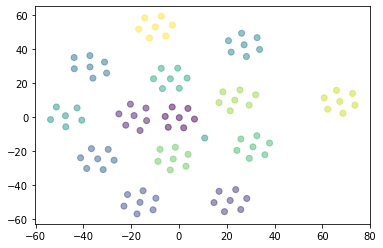

In [90]:
topic_embedding(num_time_step = 7)

In [54]:
print("x: max: {},  min:  {}".format(np.max(topic_embed[:, 0]), np.min(topic_embed[:, 0])))
print("y: max: {},  min:  {}".format(np.max(topic_embed[:, 1]), np.min(topic_embed[:, 1])))

x: max: 72.30377960205078,  min:  -67.9100341796875
y: max: 78.67923736572266,  min:  -68.87277221679688
